In [ ]:
# Paper
# Heart sound classification based on improved MFCC features and convolutional recurrent neural networks

In [1]:
%load_ext autoreload
%autoreload 2

In [176]:
!nvidia-smi

Wed Jan 31 21:53:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     Off | 00000000:01:00.0 Off |                  N/A |
|  0%   41C    P8              11W / 250W |    551MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [148]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import IPython.display as ipd
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [149]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [150]:
os.chdir('/mnt/wd4tb/thu/IConNet')

In [151]:
os.getcwd()

'/mnt/wd4tb/thu/IConNet'

In [214]:
from pathlib import Path
import numpy as np
data_dir = '/mnt/wd4tb/thu/heart_sound/Prefix_AAC_ICASSP2023/physionet/audio/'
fold = 2
preprocessed_dir = f'/mnt/wd4tb/thu/IConNet/preprocessed/fold_{fold}'
train_path = f'{preprocessed_dir}/heartsound.audio4k.train.npy'
print(train_path)
if Path(train_path).exists():
    x_train = np.load(f'{preprocessed_dir}/heartsound.audio4k.train.npy', allow_pickle=True)
    x_test = np.load(f'{preprocessed_dir}/heartsound.audio4k.test.npy', allow_pickle=True)
    classnames = np.load(f'{preprocessed_dir}/heartsound.classnames.npy', allow_pickle=True)
    y_train = np.load(f'{preprocessed_dir}/heartsound.labels_binary.train.npy', allow_pickle=True)
    y_test = np.load(f'{preprocessed_dir}/heartsound.labels_binary.test.npy', allow_pickle=True)

/mnt/wd4tb/thu/IConNet/preprocessed/fold_2/heartsound.audio4k.train.npy


In [215]:
from einops import rearrange, reduce, repeat
import torch

In [216]:
from torchaudio.transforms import MFCC
from torch.utils.data import TensorDataset, DataLoader
transforms = nn.Sequential(
        MFCC(n_mfcc=39, log_mels=True, dct_type=2)
    )
def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32, transform=None):
    x_train = torch.tensor(x_train)[:, None ,:]
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)[:, None, :]
    y_test = torch.tensor(y_test)
    
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)

    
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
    return train_loader, test_loader

/home/thu/miniconda3/envs/python3/lib/python3.9/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [217]:
batch_size = 64
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size, transform=transforms)
labels = classnames


In [218]:
from IConNet.signal import visualize_window, general_cosine_window
from IConNet.FIRConv import Downsample2
from einops import rearrange, reduce
import torch.nn.init as init

class CRNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 39, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=39),
            nn.Conv2d(39, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=32),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.Flatten()
        )
        self.lstm = nn.LSTM(input_size=1152, hidden_size=64, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, num_classes)
        self.softmax = nn.Softmax()

        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)

    def forward(self, x):
        x = self.cnn(x)
        h0 = torch.zeros(2, 64).to(device)
        c0 = torch.zeros(2, 64).to(device)
        x, _ = self.lstm(x, (h0, c0))
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x 

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = CRNN(num_classes=len(labels))
# if torch.cuda.device_count() > 1:
    # model = nn.DataParallel(model)
model.to(device)
print(model)

print("Number of parameters: %s" % count_parameters(model))

CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 39, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(39, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(39, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (lstm): LSTM(1152, 64, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_fe

In [219]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [220]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if data.shape != torch.Size([64,1,20000]):
            continue
        data = transforms(data)
        data_length = len(data)
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        del data
        gc.collect()
        torch.cuda.empty_cache()
        if 'cuda' in str(device):
            loss = F.cross_entropy(output.squeeze(), target).cuda()
        else:
            loss = F.cross_entropy(output.squeeze(), target)
        del target
        gc.collect()
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * data_length}/{train_loader_length} ({100. * batch_idx / train_loader_length:.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        train_losses.append(loss.item())

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        if data.shape != torch.Size([64,1,20000]):
            continue
        data = transforms(data)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{test_loader_length} ({100. * acc:.0f}%)\n")
    return acc

In [221]:
for batch_idx, (data, target) in enumerate(train_loader):
    if not (data.shape == torch.Size([64,1,20000])):
        print(batch_idx)
        print(data.shape)
for batch_idx, (data, target) in enumerate(test_loader):
    if not (data.shape == torch.Size([64,1,20000])):
        print(batch_idx)
        print(data.shape)  

182
torch.Size([37, 1, 20000])
60
torch.Size([49, 1, 20000])


In [222]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|          | 0/10 [00:00<?, ?it/s]/home/thu/miniconda3/envs/python3/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 0.004098360655737705/10 [00:00<14:53, 89.43s/it]

Train Epoch: 1 [0/11685 (0%)]	Loss: 0.687344


  2%|▏         | 0.168032786885246/10 [00:15<14:43, 89.81s/it]   

Train Epoch: 1 [2560/11685 (0%)]	Loss: 0.548162


  3%|▎         | 0.33196721311475436/10 [00:29<14:31, 90.16s/it]

Train Epoch: 1 [5120/11685 (1%)]	Loss: 0.516396


  5%|▍         | 0.49590163934426273/10 [00:44<14:17, 90.19s/it]

Train Epoch: 1 [7680/11685 (1%)]	Loss: 0.547734


  7%|▋         | 0.659836065573769/10 [00:59<14:03, 90.36s/it]  

Train Epoch: 1 [10240/11685 (1%)]	Loss: 0.532010


 10%|▉         | 0.9918032786885189/10 [01:28<13:10, 87.70s/it]


Test Epoch: 1	Accuracy: 2907/3889 (75%)



 10%|▉         | 0.9959016393442566/10 [01:29<13:16, 88.44s/it]

Train Epoch: 2 [0/11685 (0%)]	Loss: 0.563250


 12%|█▏        | 1.1598360655737627/10 [01:43<13:14, 89.89s/it]

Train Epoch: 2 [2560/11685 (0%)]	Loss: 0.547645


 13%|█▎        | 1.323770491803269/10 [01:58<13:06, 90.62s/it] 

Train Epoch: 2 [5120/11685 (1%)]	Loss: 0.532121


 15%|█▍        | 1.487704918032775/10 [02:13<12:47, 90.13s/it] 

Train Epoch: 2 [7680/11685 (1%)]	Loss: 0.516391


 17%|█▋        | 1.6516393442622812/10 [02:28<12:41, 91.16s/it]

Train Epoch: 2 [10240/11685 (1%)]	Loss: 0.578892


 20%|█▉        | 1.9836065573770312/10 [02:58<11:44, 87.93s/it]


Test Epoch: 2	Accuracy: 2911/3889 (75%)



 20%|█▉        | 1.9877049180327688/10 [02:58<11:51, 88.75s/it]

Train Epoch: 3 [0/11685 (0%)]	Loss: 0.578888


 22%|██▏       | 2.151639344262275/10 [03:13<11:51, 90.72s/it] 

Train Epoch: 3 [2560/11685 (0%)]	Loss: 0.563244


 23%|██▎       | 2.315573770491781/10 [03:28<11:36, 90.70s/it] 

Train Epoch: 3 [5120/11685 (1%)]	Loss: 0.578884


 25%|██▍       | 2.4795081967212873/10 [03:42<11:21, 90.60s/it]

Train Epoch: 3 [7680/11685 (1%)]	Loss: 0.547643


 26%|██▋       | 2.6434426229507935/10 [03:57<11:06, 90.54s/it]

Train Epoch: 3 [10240/11685 (1%)]	Loss: 0.422666


 30%|██▉       | 2.9754098360655434/10 [04:27<10:17, 87.93s/it] 


Test Epoch: 3	Accuracy: 2904/3889 (75%)



 30%|██▉       | 2.979508196721281/10 [04:28<10:23, 88.75s/it] 

Train Epoch: 4 [0/11685 (0%)]	Loss: 0.547653


 31%|███▏      | 3.1434426229507872/10 [04:43<10:37, 92.93s/it]

Train Epoch: 4 [2560/11685 (0%)]	Loss: 0.485139


 33%|███▎      | 3.3073770491802934/10 [04:58<10:37, 95.31s/it]

Train Epoch: 4 [5120/11685 (1%)]	Loss: 0.438276


 35%|███▍      | 3.4713114754097996/10 [05:13<10:15, 94.28s/it]

Train Epoch: 4 [7680/11685 (1%)]	Loss: 0.485140


 36%|███▋      | 3.6352459016393057/10 [05:29<10:28, 98.81s/it] 

Train Epoch: 4 [10240/11685 (1%)]	Loss: 0.531918


 40%|███▉      | 3.9672131147540557/10 [06:00<09:17, 92.41s/it]


Test Epoch: 4	Accuracy: 2909/3889 (75%)



 40%|███▉      | 3.9713114754097933/10 [06:00<09:28, 94.38s/it]

Train Epoch: 5 [0/11685 (0%)]	Loss: 0.547631


 41%|████▏     | 4.135245901639314/10 [06:16<09:48, 100.29s/it]

Train Epoch: 5 [2560/11685 (0%)]	Loss: 0.547624


 43%|████▎     | 4.299180327868838/10 [06:32<08:50, 93.05s/it] 

Train Epoch: 5 [5120/11685 (1%)]	Loss: 0.641387


 45%|████▍     | 4.463114754098362/10 [06:47<08:56, 96.91s/it] 

Train Epoch: 5 [7680/11685 (1%)]	Loss: 0.485141


 46%|████▋     | 4.6270491803278855/10 [07:02<08:31, 95.19s/it]

Train Epoch: 5 [10240/11685 (1%)]	Loss: 0.422637


 50%|████▉     | 4.959016393442671/10 [07:33<07:29, 89.14s/it] 


Test Epoch: 5	Accuracy: 2911/3889 (75%)



 50%|████▉     | 4.9631147540984095/10 [07:33<07:31, 89.59s/it]

Train Epoch: 6 [0/11685 (0%)]	Loss: 0.578887


 51%|█████▏    | 5.127049180327933/10 [07:48<07:23, 90.98s/it] 

Train Epoch: 6 [2560/11685 (0%)]	Loss: 0.532017


 53%|█████▎    | 5.290983606557457/10 [08:03<07:19, 93.44s/it] 

Train Epoch: 6 [5120/11685 (1%)]	Loss: 0.485137


 55%|█████▍    | 5.454918032786981/10 [08:18<06:51, 90.63s/it] 

Train Epoch: 6 [7680/11685 (1%)]	Loss: 0.485140


 56%|█████▌    | 5.618852459016505/10 [08:33<06:34, 89.97s/it] 

Train Epoch: 6 [10240/11685 (1%)]	Loss: 0.563262


 60%|█████▉    | 5.950819672131291/10 [09:02<05:52, 86.93s/it] 


Test Epoch: 6	Accuracy: 2910/3889 (75%)



 60%|█████▉    | 5.954918032787029/10 [09:03<05:57, 88.33s/it]

Train Epoch: 7 [0/11685 (0%)]	Loss: 0.485137


 61%|██████    | 6.118852459016553/10 [09:17<05:50, 90.32s/it] 

Train Epoch: 7 [2560/11685 (0%)]	Loss: 0.594512


 63%|██████▎   | 6.282786885246077/10 [09:32<05:36, 90.51s/it] 

Train Epoch: 7 [5120/11685 (1%)]	Loss: 0.532012


 64%|██████▍   | 6.446721311475601/10 [09:47<05:20, 90.09s/it] 

Train Epoch: 7 [7680/11685 (1%)]	Loss: 0.610131


 66%|██████▌   | 6.610655737705125/10 [10:02<05:13, 92.64s/it] 

Train Epoch: 7 [10240/11685 (1%)]	Loss: 0.547640


 69%|██████▉   | 6.942622950819911/10 [10:32<04:30, 88.42s/it] 


Test Epoch: 7	Accuracy: 2910/3889 (75%)



 69%|██████▉   | 6.946721311475649/10 [10:32<04:31, 88.93s/it]

Train Epoch: 8 [0/11685 (0%)]	Loss: 0.532012


 71%|███████   | 7.110655737705173/10 [10:47<04:28, 92.87s/it] 

Train Epoch: 8 [2560/11685 (0%)]	Loss: 0.438263


 73%|███████▎  | 7.274590163934697/10 [11:02<04:07, 90.86s/it] 

Train Epoch: 8 [5120/11685 (1%)]	Loss: 0.516387


 74%|███████▍  | 7.438524590164221/10 [11:17<03:53, 91.06s/it] 

Train Epoch: 8 [7680/11685 (1%)]	Loss: 0.500763


 76%|███████▌  | 7.602459016393745/10 [11:32<03:41, 92.42s/it] 

Train Epoch: 8 [10240/11685 (1%)]	Loss: 0.469512


 79%|███████▉  | 7.934426229508531/10 [12:02<03:06, 90.11s/it] 


Test Epoch: 8	Accuracy: 2910/3889 (75%)



 79%|███████▉  | 7.938524590164269/10 [12:03<03:08, 91.36s/it]

Train Epoch: 9 [0/11685 (0%)]	Loss: 0.625762


 81%|████████  | 8.10245901639377/10 [12:18<02:54, 92.15s/it]  

Train Epoch: 9 [2560/11685 (0%)]	Loss: 0.594513


 83%|████████▎ | 8.266393442623258/10 [12:33<02:35, 89.72s/it]

Train Epoch: 9 [5120/11685 (1%)]	Loss: 0.485140


 84%|████████▍ | 8.430327868852746/10 [12:48<02:21, 90.09s/it]

Train Epoch: 9 [7680/11685 (1%)]	Loss: 0.500764


 86%|████████▌ | 8.594262295082235/10 [13:03<02:07, 90.82s/it]

Train Epoch: 9 [10240/11685 (1%)]	Loss: 0.516389


 89%|████████▉ | 8.926229508196949/10 [13:32<01:33, 87.11s/it]


Test Epoch: 9	Accuracy: 2905/3889 (75%)



 89%|████████▉ | 8.930327868852686/10 [13:33<01:33, 87.73s/it]

Train Epoch: 10 [0/11685 (0%)]	Loss: 0.563262


 91%|█████████ | 9.094262295082174/10 [13:48<01:23, 91.75s/it]

Train Epoch: 10 [2560/11685 (0%)]	Loss: 0.469544


 93%|█████████▎| 9.258196721311663/10 [14:03<01:07, 91.40s/it]

Train Epoch: 10 [5120/11685 (1%)]	Loss: 0.500762


 94%|█████████▍| 9.422131147541151/10 [14:18<00:52, 91.29s/it]

Train Epoch: 10 [7680/11685 (1%)]	Loss: 0.532009


 96%|█████████▌| 9.58606557377064/10 [14:33<00:38, 92.37s/it] 

Train Epoch: 10 [10240/11685 (1%)]	Loss: 0.532023


 99%|█████████▉| 9.918032786885354/10 [15:02<00:07, 91.04s/it]


Test Epoch: 10	Accuracy: 2909/3889 (75%)



In [223]:
train_losses1 = train_losses
test_accuracy1 = test_accuracy
print(train_losses1[-1], test_accuracy1[-1])

0.5476394295692444 0.7480071997942916


In [224]:
model_path = f'saved_models/crnn/fold_{fold}/physionet_10epochs.pt'
print(model_path)

saved_models/crnn/fold_2/physionet_10epochs.pt


In [225]:
torch.save(model.state_dict(), model_path)
torch.save({
        'model_state_dict': model.state_dict(),
        'loss': train_losses[-1],
    }, model_path)

Text(0.5, 1.0, 'training loss')

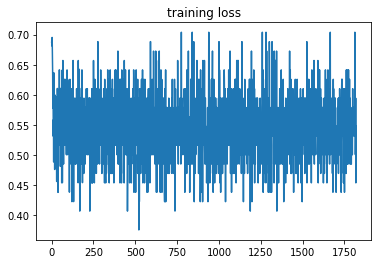

In [226]:
plt.plot(train_losses)
plt.title("training loss")

0.7480071997942916


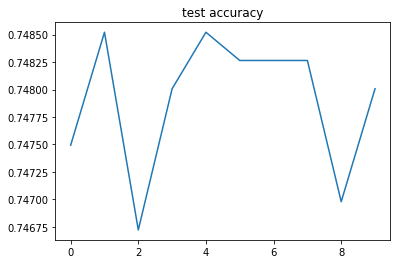

In [227]:
plt.plot(test_accuracy)
plt.title("test accuracy")
print(test_accuracy[-1])

In [228]:
from torchmetrics import ConfusionMatrix
metric_cm = ConfusionMatrix(task='binary', num_classes=2).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    if data.shape != torch.Size([64,1,20000]):
            continue
    data = transforms(data)
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    metric_cm(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
    

In [229]:
cm = metric_cm.compute()
print(cm)

tensor([[   0,  931],
        [   0, 2909]], device='cuda:0')


In [230]:
2909/(2909+931)

0.7575520833333333

## 60 epochs

In [231]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

In [232]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1 + n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|          | 0.004098360655737705/50 [00:00<1:18:02, 93.65s/it]

Train Epoch: 11 [0/11685 (0%)]	Loss: 0.563262


  0%|          | 0.168032786885246/50 [00:15<1:14:59, 90.30s/it]   

Train Epoch: 11 [2560/11685 (0%)]	Loss: 0.547637


  1%|          | 0.33196721311475436/50 [00:30<1:14:50, 90.41s/it]

Train Epoch: 11 [5120/11685 (1%)]	Loss: 0.532012


  1%|          | 0.49590163934426273/50 [00:44<1:14:54, 90.78s/it]

Train Epoch: 11 [7680/11685 (1%)]	Loss: 0.563262


  1%|▏         | 0.659836065573769/50 [00:59<1:14:36, 90.74s/it]  

Train Epoch: 11 [10240/11685 (1%)]	Loss: 0.641387


  2%|▏         | 0.9918032786885189/50 [01:29<1:11:54, 88.04s/it]


Test Epoch: 11	Accuracy: 2907/3889 (75%)



  2%|▏         | 0.9959016393442566/50 [01:29<1:12:52, 89.23s/it]

Train Epoch: 12 [0/11685 (0%)]	Loss: 0.532012


  2%|▏         | 1.1598360655737627/50 [01:44<1:13:31, 90.33s/it]

Train Epoch: 12 [2560/11685 (0%)]	Loss: 0.500762


  3%|▎         | 1.323770491803269/50 [01:59<1:13:26, 90.52s/it] 

Train Epoch: 12 [5120/11685 (1%)]	Loss: 0.578887


  3%|▎         | 1.487704918032775/50 [02:14<1:13:43, 91.19s/it] 

Train Epoch: 12 [7680/11685 (1%)]	Loss: 0.578887


  3%|▎         | 1.6516393442622812/50 [02:29<1:13:26, 91.15s/it]

Train Epoch: 12 [10240/11685 (1%)]	Loss: 0.500762


  4%|▍         | 1.9836065573770312/50 [02:58<1:10:44, 88.39s/it]


Test Epoch: 12	Accuracy: 2907/3889 (75%)



  4%|▍         | 1.9877049180327688/50 [02:59<1:11:24, 89.23s/it]

Train Epoch: 13 [0/11685 (0%)]	Loss: 0.547637


  4%|▍         | 2.151639344262275/50 [03:14<1:13:46, 92.50s/it] 

Train Epoch: 13 [2560/11685 (0%)]	Loss: 0.532012


  5%|▍         | 2.315573770491781/50 [03:29<1:13:01, 91.90s/it] 

Train Epoch: 13 [5120/11685 (1%)]	Loss: 0.532012


  5%|▍         | 2.4795081967212873/50 [03:44<1:13:12, 92.44s/it]

Train Epoch: 13 [7680/11685 (1%)]	Loss: 0.641387


  5%|▌         | 2.6434426229507935/50 [03:59<1:14:04, 93.84s/it]

Train Epoch: 13 [10240/11685 (1%)]	Loss: 0.407012


  6%|▌         | 2.9754098360655434/50 [04:28<1:09:32, 88.72s/it]


Test Epoch: 13	Accuracy: 2908/3889 (75%)



  6%|▌         | 2.979508196721281/50 [04:29<1:10:09, 89.53s/it] 

Train Epoch: 14 [0/11685 (0%)]	Loss: 0.610137


  6%|▋         | 3.1434426229507872/50 [04:44<1:11:08, 91.10s/it]

Train Epoch: 14 [2560/11685 (0%)]	Loss: 0.594512


  7%|▋         | 3.3073770491802934/50 [04:59<1:11:25, 91.78s/it]

Train Epoch: 14 [5120/11685 (1%)]	Loss: 0.532012


  7%|▋         | 3.4713114754097996/50 [05:13<1:10:18, 90.66s/it]

Train Epoch: 14 [7680/11685 (1%)]	Loss: 0.625762


  7%|▋         | 3.6352459016393057/50 [05:28<1:09:57, 90.53s/it]

Train Epoch: 14 [10240/11685 (1%)]	Loss: 0.532012


  8%|▊         | 3.9672131147540557/50 [05:58<1:07:36, 88.13s/it]


Test Epoch: 14	Accuracy: 2907/3889 (75%)



  8%|▊         | 3.9713114754097933/50 [05:58<1:08:25, 89.19s/it]

Train Epoch: 15 [0/11685 (0%)]	Loss: 0.563262


  8%|▊         | 4.135245901639314/50 [06:13<1:09:40, 91.14s/it] 

Train Epoch: 15 [2560/11685 (0%)]	Loss: 0.453887


  9%|▊         | 4.299180327868838/50 [06:28<1:09:38, 91.43s/it] 

Train Epoch: 15 [5120/11685 (1%)]	Loss: 0.500762


  9%|▉         | 4.463114754098362/50 [06:43<1:08:33, 90.33s/it] 

Train Epoch: 15 [7680/11685 (1%)]	Loss: 0.641390


  9%|▉         | 4.6270491803278855/50 [06:57<1:08:29, 90.58s/it]

Train Epoch: 15 [10240/11685 (1%)]	Loss: 0.578887


 10%|▉         | 4.959016393442671/50 [07:27<1:06:23, 88.45s/it] 


Test Epoch: 15	Accuracy: 2909/3889 (75%)



 10%|▉         | 4.9631147540984095/50 [07:27<1:07:07, 89.43s/it]

Train Epoch: 16 [0/11685 (0%)]	Loss: 0.516387


 10%|█         | 5.127049180327933/50 [07:42<1:08:54, 92.15s/it] 

Train Epoch: 16 [2560/11685 (0%)]	Loss: 0.547637


 11%|█         | 5.290983606557457/50 [07:57<1:08:04, 91.35s/it] 

Train Epoch: 16 [5120/11685 (1%)]	Loss: 0.500762


 11%|█         | 5.454918032786981/50 [08:12<1:07:19, 90.69s/it] 

Train Epoch: 16 [7680/11685 (1%)]	Loss: 0.532012


 11%|█         | 5.618852459016505/50 [08:27<1:07:03, 90.66s/it] 

Train Epoch: 16 [10240/11685 (1%)]	Loss: 0.532012


 12%|█▏        | 5.950819672131291/50 [08:57<1:04:50, 88.33s/it] 


Test Epoch: 16	Accuracy: 2908/3889 (75%)



 12%|█▏        | 5.954918032787029/50 [08:57<1:05:20, 89.02s/it]

Train Epoch: 17 [0/11685 (0%)]	Loss: 0.407012


 12%|█▏        | 6.118852459016553/50 [09:12<1:06:05, 90.38s/it] 

Train Epoch: 17 [2560/11685 (0%)]	Loss: 0.469512


 13%|█▎        | 6.282786885246077/50 [09:27<1:08:37, 94.19s/it] 

Train Epoch: 17 [5120/11685 (1%)]	Loss: 0.547637


 13%|█▎        | 6.446721311475601/50 [09:42<1:05:04, 89.64s/it] 

Train Epoch: 17 [7680/11685 (1%)]	Loss: 0.485137


 13%|█▎        | 6.610655737705125/50 [09:56<1:05:45, 90.92s/it] 

Train Epoch: 17 [10240/11685 (1%)]	Loss: 0.516387


 14%|█▍        | 6.942622950819911/50 [10:26<1:02:55, 87.69s/it] 


Test Epoch: 17	Accuracy: 2913/3889 (75%)



 14%|█▍        | 6.946721311475649/50 [10:26<1:03:30, 88.50s/it]

Train Epoch: 18 [0/11685 (0%)]	Loss: 0.532012


 14%|█▍        | 7.110655737705173/50 [10:41<1:05:12, 91.23s/it] 

Train Epoch: 18 [2560/11685 (0%)]	Loss: 0.453887


 15%|█▍        | 7.274590163934697/50 [10:56<1:03:46, 89.56s/it] 

Train Epoch: 18 [5120/11685 (1%)]	Loss: 0.453887


 15%|█▍        | 7.438524590164221/50 [11:11<1:04:56, 91.54s/it] 

Train Epoch: 18 [7680/11685 (1%)]	Loss: 0.594512


 15%|█▌        | 7.602459016393745/50 [11:26<1:03:47, 90.28s/it] 

Train Epoch: 18 [10240/11685 (1%)]	Loss: 0.563262


 16%|█▌        | 7.934426229508531/50 [11:55<1:01:32, 87.79s/it] 


Test Epoch: 18	Accuracy: 2907/3889 (75%)



 16%|█▌        | 7.938524590164269/50 [11:56<1:02:18, 88.89s/it]

Train Epoch: 19 [0/11685 (0%)]	Loss: 0.485137


 16%|█▌        | 8.10245901639377/50 [12:10<1:03:02, 90.29s/it]  

Train Epoch: 19 [2560/11685 (0%)]	Loss: 0.547637


 17%|█▋        | 8.266393442623258/50 [12:25<1:03:23, 91.14s/it]

Train Epoch: 19 [5120/11685 (1%)]	Loss: 0.547637


 17%|█▋        | 8.430327868852746/50 [12:40<1:04:02, 92.43s/it]

Train Epoch: 19 [7680/11685 (1%)]	Loss: 0.500762


 17%|█▋        | 8.594262295082235/50 [12:55<1:03:07, 91.47s/it]

Train Epoch: 19 [10240/11685 (1%)]	Loss: 0.578887


 18%|█▊        | 8.926229508196949/50 [13:25<1:00:16, 88.04s/it]


Test Epoch: 19	Accuracy: 2908/3889 (75%)



 18%|█▊        | 8.930327868852686/50 [13:25<1:00:44, 88.74s/it]

Train Epoch: 20 [0/11685 (0%)]	Loss: 0.485137


 18%|█▊        | 9.094262295082174/50 [13:40<1:03:32, 93.21s/it]

Train Epoch: 20 [2560/11685 (0%)]	Loss: 0.453887


 19%|█▊        | 9.258196721311663/50 [13:55<1:01:20, 90.33s/it]

Train Epoch: 20 [5120/11685 (1%)]	Loss: 0.578887


 19%|█▉        | 9.422131147541151/50 [14:10<1:02:38, 92.62s/it]

Train Epoch: 20 [7680/11685 (1%)]	Loss: 0.469512


 19%|█▉        | 9.58606557377064/50 [14:24<1:00:49, 90.31s/it] 

Train Epoch: 20 [10240/11685 (1%)]	Loss: 0.578887


 20%|█▉        | 9.918032786885354/50 [14:54<57:44, 86.43s/it]  


Test Epoch: 20	Accuracy: 2906/3889 (75%)



 20%|█▉        | 9.92213114754109/50 [14:54<58:30, 87.59s/it] 

Train Epoch: 21 [0/11685 (0%)]	Loss: 0.563262


 20%|██        | 10.086065573770579/50 [15:09<59:32, 89.51s/it]

Train Epoch: 21 [2560/11685 (0%)]	Loss: 0.610137


 21%|██        | 10.250000000000068/50 [15:24<1:02:23, 94.17s/it]

Train Epoch: 21 [5120/11685 (1%)]	Loss: 0.594512


 21%|██        | 10.413934426229556/50 [15:39<59:37, 90.38s/it]  

Train Epoch: 21 [7680/11685 (1%)]	Loss: 0.500762


 21%|██        | 10.577868852459044/50 [15:54<59:25, 90.44s/it]

Train Epoch: 21 [10240/11685 (1%)]	Loss: 0.485137


 22%|██▏       | 10.909836065573758/50 [16:23<57:57, 88.97s/it]  


Test Epoch: 21	Accuracy: 2904/3889 (75%)



 22%|██▏       | 10.913934426229496/50 [16:24<58:19, 89.53s/it]

Train Epoch: 22 [0/11685 (0%)]	Loss: 0.516387


 22%|██▏       | 11.077868852458984/50 [16:38<58:59, 90.94s/it]  

Train Epoch: 22 [2560/11685 (0%)]	Loss: 0.532012


 22%|██▏       | 11.241803278688472/50 [16:54<1:05:07, 100.81s/it]

Train Epoch: 22 [5120/11685 (1%)]	Loss: 0.485137


 23%|██▎       | 11.40573770491796/50 [17:11<1:05:09, 101.30s/it] 

Train Epoch: 22 [7680/11685 (1%)]	Loss: 0.469512


 23%|██▎       | 11.569672131147449/50 [17:28<1:05:21, 102.04s/it]

Train Epoch: 22 [10240/11685 (1%)]	Loss: 0.500762


 24%|██▍       | 11.901639344262163/50 [18:01<1:03:09, 99.46s/it] 


Test Epoch: 22	Accuracy: 2907/3889 (75%)



 24%|██▍       | 11.9057377049179/50 [18:02<1:03:28, 99.98s/it]  

Train Epoch: 23 [0/11685 (0%)]	Loss: 0.500762


 24%|██▍       | 12.069672131147389/50 [18:18<1:03:48, 100.93s/it]

Train Epoch: 23 [2560/11685 (0%)]	Loss: 0.469512


 24%|██▍       | 12.233606557376877/50 [18:35<1:04:51, 103.04s/it]

Train Epoch: 23 [5120/11685 (1%)]	Loss: 0.547637


 25%|██▍       | 12.397540983606365/50 [18:52<1:04:12, 102.47s/it]

Train Epoch: 23 [7680/11685 (1%)]	Loss: 0.469512


 25%|██▌       | 12.561475409835854/50 [19:09<1:04:36, 103.55s/it]

Train Epoch: 23 [10240/11685 (1%)]	Loss: 0.547637


 26%|██▌       | 12.893442622950568/50 [19:42<1:01:14, 99.01s/it] 


Test Epoch: 23	Accuracy: 2908/3889 (75%)



 26%|██▌       | 12.897540983606305/50 [19:42<1:01:57, 100.21s/it]

Train Epoch: 24 [0/11685 (0%)]	Loss: 0.641387


 26%|██▌       | 13.061475409835793/50 [19:59<1:03:25, 103.02s/it]

Train Epoch: 24 [2560/11685 (0%)]	Loss: 0.641387


 26%|██▋       | 13.225409836065282/50 [20:16<1:03:24, 103.47s/it]

Train Epoch: 24 [5120/11685 (1%)]	Loss: 0.594512


 27%|██▋       | 13.38934426229477/50 [20:33<1:01:39, 101.06s/it] 

Train Epoch: 24 [7680/11685 (1%)]	Loss: 0.469512


 27%|██▋       | 13.553278688524259/50 [20:49<1:02:26, 102.80s/it]

Train Epoch: 24 [10240/11685 (1%)]	Loss: 0.516387


 28%|██▊       | 13.885245901638973/50 [21:22<59:29, 98.83s/it]   


Test Epoch: 24	Accuracy: 2909/3889 (75%)



 28%|██▊       | 13.88934426229471/50 [21:23<1:00:03, 99.79s/it]

Train Epoch: 25 [0/11685 (0%)]	Loss: 0.547637


 28%|██▊       | 14.053278688524198/50 [21:40<1:01:03, 101.92s/it]

Train Epoch: 25 [2560/11685 (0%)]	Loss: 0.578887


 28%|██▊       | 14.217213114753687/50 [21:56<1:02:01, 103.99s/it]

Train Epoch: 25 [5120/11685 (1%)]	Loss: 0.578887


 29%|██▉       | 14.381147540983175/50 [22:13<1:00:31, 101.96s/it]

Train Epoch: 25 [7680/11685 (1%)]	Loss: 0.532012


 29%|██▉       | 14.545081967212663/50 [22:30<59:40, 100.99s/it]  

Train Epoch: 25 [10240/11685 (1%)]	Loss: 0.469512


 30%|██▉       | 14.877049180327377/50 [23:03<59:21, 101.39s/it]  


Test Epoch: 25	Accuracy: 2911/3889 (75%)



 30%|██▉       | 14.881147540983115/50 [23:04<59:52, 102.29s/it]

Train Epoch: 26 [0/11685 (0%)]	Loss: 0.578887


 30%|███       | 15.045081967212603/50 [23:20<59:48, 102.67s/it]  

Train Epoch: 26 [2560/11685 (0%)]	Loss: 0.547637


 30%|███       | 15.209016393442091/50 [23:37<59:47, 103.11s/it]  

Train Epoch: 26 [5120/11685 (1%)]	Loss: 0.578887


 31%|███       | 15.37295081967158/50 [23:53<52:18, 90.62s/it]    

Train Epoch: 26 [7680/11685 (1%)]	Loss: 0.360137


 31%|███       | 15.536885245901068/50 [24:08<52:00, 90.55s/it]

Train Epoch: 26 [10240/11685 (1%)]	Loss: 0.485137


 32%|███▏      | 15.868852459015782/50 [24:37<49:37, 87.24s/it]


Test Epoch: 26	Accuracy: 2910/3889 (75%)



 32%|███▏      | 15.87295081967152/50 [24:38<51:00, 89.68s/it] 

Train Epoch: 27 [0/11685 (0%)]	Loss: 0.532012


 32%|███▏      | 16.036885245901022/50 [24:52<51:23, 90.78s/it]

Train Epoch: 27 [2560/11685 (0%)]	Loss: 0.578887


 32%|███▏      | 16.20081967213058/50 [25:08<52:23, 93.02s/it] 

Train Epoch: 27 [5120/11685 (1%)]	Loss: 0.578887


 33%|███▎      | 16.36475409836014/50 [25:22<50:40, 90.41s/it] 

Train Epoch: 27 [7680/11685 (1%)]	Loss: 0.532012


 33%|███▎      | 16.5286885245897/50 [25:38<50:19, 90.21s/it]  

Train Epoch: 27 [10240/11685 (1%)]	Loss: 0.516387


 34%|███▎      | 16.86065573770456/50 [26:07<52:26, 94.93s/it] 


Test Epoch: 27	Accuracy: 2911/3889 (75%)



 34%|███▎      | 16.864754098360297/50 [26:08<53:27, 96.79s/it]

Train Epoch: 28 [0/11685 (0%)]	Loss: 0.516387


 34%|███▍      | 17.028688524589857/50 [26:24<50:47, 92.42s/it] 

Train Epoch: 28 [2560/11685 (0%)]	Loss: 0.563262


 34%|███▍      | 17.192622950819416/50 [26:39<51:03, 93.39s/it]

Train Epoch: 28 [5120/11685 (1%)]	Loss: 0.469512


 35%|███▍      | 17.356557377048976/50 [26:54<48:55, 89.92s/it]

Train Epoch: 28 [7680/11685 (1%)]	Loss: 0.594512


 35%|███▌      | 17.520491803278535/50 [27:08<49:07, 90.76s/it]

Train Epoch: 28 [10240/11685 (1%)]	Loss: 0.532012


 36%|███▌      | 17.852459016393393/50 [27:41<52:46, 98.51s/it] 


Test Epoch: 28	Accuracy: 2912/3889 (75%)



 36%|███▌      | 17.856557377049132/50 [27:42<53:06, 99.12s/it]

Train Epoch: 29 [0/11685 (0%)]	Loss: 0.500762


 36%|███▌      | 18.02049180327869/50 [27:58<54:12, 101.71s/it] 

Train Epoch: 29 [2560/11685 (0%)]	Loss: 0.641387


 36%|███▋      | 18.18442622950825/50 [28:15<53:46, 101.42s/it] 

Train Epoch: 29 [5120/11685 (1%)]	Loss: 0.547637


 37%|███▋      | 18.34836065573781/50 [28:32<54:10, 102.70s/it] 

Train Epoch: 29 [7680/11685 (1%)]	Loss: 0.532012


 37%|███▋      | 18.51229508196737/50 [28:48<53:25, 101.81s/it] 

Train Epoch: 29 [10240/11685 (1%)]	Loss: 0.485137


 38%|███▊      | 18.844262295082228/50 [29:22<51:27, 99.11s/it] 


Test Epoch: 29	Accuracy: 2905/3889 (75%)



 38%|███▊      | 18.848360655737967/50 [29:22<51:56, 100.03s/it]

Train Epoch: 30 [0/11685 (0%)]	Loss: 0.485137


 38%|███▊      | 19.012295081967526/50 [29:39<52:16, 101.20s/it]

Train Epoch: 30 [2560/11685 (0%)]	Loss: 0.578887


 38%|███▊      | 19.176229508197085/50 [29:56<52:08, 101.48s/it]

Train Epoch: 30 [5120/11685 (1%)]	Loss: 0.547637


 39%|███▊      | 19.340163934426645/50 [30:12<51:58, 101.71s/it]

Train Epoch: 30 [7680/11685 (1%)]	Loss: 0.563262


 39%|███▉      | 19.504098360656204/50 [30:29<52:12, 102.73s/it]

Train Epoch: 30 [10240/11685 (1%)]	Loss: 0.657012


 40%|███▉      | 19.836065573771062/50 [31:02<49:38, 98.74s/it] 


Test Epoch: 30	Accuracy: 2908/3889 (75%)



 40%|███▉      | 19.8401639344268/50 [31:03<50:04, 99.63s/it]  

Train Epoch: 31 [0/11685 (0%)]	Loss: 0.500762


 40%|████      | 20.00409836065636/50 [31:19<50:37, 101.26s/it] 

Train Epoch: 31 [2560/11685 (0%)]	Loss: 0.500762


 40%|████      | 20.16803278688592/50 [31:36<50:36, 101.78s/it] 

Train Epoch: 31 [5120/11685 (1%)]	Loss: 0.532012


 41%|████      | 20.33196721311548/50 [31:52<50:00, 101.12s/it] 

Train Epoch: 31 [7680/11685 (1%)]	Loss: 0.547637


 41%|████      | 20.49590163934504/50 [32:09<49:52, 101.41s/it] 

Train Epoch: 31 [10240/11685 (1%)]	Loss: 0.578887


 42%|████▏     | 20.827868852459897/50 [32:42<47:40, 98.04s/it] 


Test Epoch: 31	Accuracy: 2903/3889 (75%)



 42%|████▏     | 20.831967213115636/50 [32:42<48:11, 99.14s/it]

Train Epoch: 32 [0/11685 (0%)]	Loss: 0.516387


 42%|████▏     | 20.995901639345195/50 [32:59<49:03, 101.50s/it]

Train Epoch: 32 [2560/11685 (0%)]	Loss: 0.610137


 42%|████▏     | 21.159836065574755/50 [33:16<48:59, 101.92s/it]

Train Epoch: 32 [5120/11685 (1%)]	Loss: 0.657012


 43%|████▎     | 21.323770491804314/50 [33:32<48:50, 102.20s/it]

Train Epoch: 32 [7680/11685 (1%)]	Loss: 0.547637


 43%|████▎     | 21.487704918033874/50 [33:49<48:37, 102.32s/it]

Train Epoch: 32 [10240/11685 (1%)]	Loss: 0.610137


 44%|████▎     | 21.81967213114873/50 [34:22<46:10, 98.30s/it]  


Test Epoch: 32	Accuracy: 2909/3889 (75%)



 44%|████▎     | 21.82377049180447/50 [34:23<46:25, 98.86s/it]

Train Epoch: 33 [0/11685 (0%)]	Loss: 0.547637


 44%|████▍     | 21.98770491803403/50 [34:39<47:15, 101.21s/it] 

Train Epoch: 33 [2560/11685 (0%)]	Loss: 0.485137


 44%|████▍     | 22.15163934426359/50 [34:56<46:44, 100.71s/it] 

Train Epoch: 33 [5120/11685 (1%)]	Loss: 0.578887


 45%|████▍     | 22.31557377049315/50 [35:12<46:54, 101.67s/it] 

Train Epoch: 33 [7680/11685 (1%)]	Loss: 0.516387


 45%|████▍     | 22.47950819672271/50 [35:29<46:38, 101.68s/it] 

Train Epoch: 33 [10240/11685 (1%)]	Loss: 0.625762


 46%|████▌     | 22.811475409837566/50 [36:02<44:38, 98.52s/it] 


Test Epoch: 33	Accuracy: 2905/3889 (75%)



 46%|████▌     | 22.815573770493305/50 [36:03<44:51, 99.01s/it]

Train Epoch: 34 [0/11685 (0%)]	Loss: 0.547637


 46%|████▌     | 22.979508196722865/50 [36:19<45:32, 101.11s/it]

Train Epoch: 34 [2560/11685 (0%)]	Loss: 0.672637


 46%|████▋     | 23.143442622952424/50 [36:36<45:37, 101.93s/it]

Train Epoch: 34 [5120/11685 (1%)]	Loss: 0.532012


 47%|████▋     | 23.307377049181984/50 [36:53<44:47, 100.67s/it]

Train Epoch: 34 [7680/11685 (1%)]	Loss: 0.547637


 47%|████▋     | 23.471311475411543/50 [37:09<45:06, 102.02s/it]

Train Epoch: 34 [10240/11685 (1%)]	Loss: 0.485137


 48%|████▊     | 23.8032786885264/50 [37:42<43:06, 98.75s/it]   


Test Epoch: 34	Accuracy: 2906/3889 (75%)



 48%|████▊     | 23.80737704918214/50 [37:42<43:26, 99.50s/it]

Train Epoch: 35 [0/11685 (0%)]	Loss: 0.516387


 48%|████▊     | 23.9713114754117/50 [37:59<44:00, 101.46s/it]  

Train Epoch: 35 [2560/11685 (0%)]	Loss: 0.610137


 48%|████▊     | 24.13524590164126/50 [38:16<43:22, 100.63s/it] 

Train Epoch: 35 [5120/11685 (1%)]	Loss: 0.547637


 49%|████▊     | 24.29918032787082/50 [38:32<43:26, 101.42s/it] 

Train Epoch: 35 [7680/11685 (1%)]	Loss: 0.578887


 49%|████▉     | 24.463114754100378/50 [38:49<44:03, 103.53s/it]

Train Epoch: 35 [10240/11685 (1%)]	Loss: 0.547637


 50%|████▉     | 24.795081967215236/50 [39:22<41:43, 99.34s/it] 


Test Epoch: 35	Accuracy: 2905/3889 (75%)



 50%|████▉     | 24.799180327870975/50 [39:23<42:12, 100.50s/it]

Train Epoch: 36 [0/11685 (0%)]	Loss: 0.500762


 50%|████▉     | 24.963114754100534/50 [39:39<43:10, 103.48s/it]

Train Epoch: 36 [2560/11685 (0%)]	Loss: 0.641387


 50%|█████     | 25.127049180330093/50 [39:56<42:51, 103.40s/it]

Train Epoch: 36 [5120/11685 (1%)]	Loss: 0.657012


 51%|█████     | 25.290983606559653/50 [40:13<41:26, 100.63s/it]

Train Epoch: 36 [7680/11685 (1%)]	Loss: 0.485137


 51%|█████     | 25.454918032789212/50 [40:29<41:28, 101.40s/it]

Train Epoch: 36 [10240/11685 (1%)]	Loss: 0.641387


 52%|█████▏    | 25.78688524590407/50 [41:02<40:01, 99.16s/it]  


Test Epoch: 36	Accuracy: 2909/3889 (75%)



 52%|█████▏    | 25.79098360655981/50 [41:03<40:11, 99.60s/it]

Train Epoch: 37 [0/11685 (0%)]	Loss: 0.532012


 52%|█████▏    | 25.95491803278937/50 [41:19<41:06, 102.58s/it] 

Train Epoch: 37 [2560/11685 (0%)]	Loss: 0.500762


 52%|█████▏    | 26.118852459018928/50 [41:36<40:04, 100.67s/it]

Train Epoch: 37 [5120/11685 (1%)]	Loss: 0.516387


 53%|█████▎    | 26.282786885248488/50 [41:53<40:18, 101.97s/it]

Train Epoch: 37 [7680/11685 (1%)]	Loss: 0.625762


 53%|█████▎    | 26.446721311478047/50 [42:09<39:39, 101.04s/it]

Train Epoch: 37 [10240/11685 (1%)]	Loss: 0.594512


 54%|█████▎    | 26.778688524592905/50 [42:42<38:07, 98.52s/it] 


Test Epoch: 37	Accuracy: 2908/3889 (75%)



 54%|█████▎    | 26.782786885248644/50 [42:43<39:56, 103.24s/it]

Train Epoch: 38 [0/11685 (0%)]	Loss: 0.563262


 54%|█████▍    | 26.946721311478203/50 [42:59<39:13, 102.09s/it]

Train Epoch: 38 [2560/11685 (0%)]	Loss: 0.625762


 54%|█████▍    | 27.110655737707763/50 [43:16<38:43, 101.50s/it]

Train Epoch: 38 [5120/11685 (1%)]	Loss: 0.610137


 55%|█████▍    | 27.274590163937322/50 [43:33<38:08, 100.70s/it]

Train Epoch: 38 [7680/11685 (1%)]	Loss: 0.438262


 55%|█████▍    | 27.43852459016688/50 [43:49<37:47, 100.52s/it] 

Train Epoch: 38 [10240/11685 (1%)]	Loss: 0.500762


 56%|█████▌    | 27.77049180328174/50 [44:22<36:25, 98.32s/it]  


Test Epoch: 38	Accuracy: 2909/3889 (75%)



 56%|█████▌    | 27.77459016393748/50 [44:22<36:43, 99.15s/it]

Train Epoch: 39 [0/11685 (0%)]	Loss: 0.625762


 56%|█████▌    | 27.938524590167038/50 [44:39<36:53, 100.35s/it]

Train Epoch: 39 [2560/11685 (0%)]	Loss: 0.532012


 56%|█████▌    | 28.102459016396597/50 [44:55<36:54, 101.15s/it]

Train Epoch: 39 [5120/11685 (1%)]	Loss: 0.563262


 57%|█████▋    | 28.266393442626157/50 [45:12<36:55, 101.92s/it]

Train Epoch: 39 [7680/11685 (1%)]	Loss: 0.563262


 57%|█████▋    | 28.430327868855716/50 [45:29<36:14, 100.79s/it]

Train Epoch: 39 [10240/11685 (1%)]	Loss: 0.578887


 58%|█████▊    | 28.762295081970574/50 [46:02<34:45, 98.22s/it] 


Test Epoch: 39	Accuracy: 2911/3889 (75%)



 58%|█████▊    | 28.766393442626313/50 [46:02<34:57, 98.80s/it]

Train Epoch: 40 [0/11685 (0%)]	Loss: 0.688262


 58%|█████▊    | 28.930327868855873/50 [46:19<35:46, 101.85s/it]

Train Epoch: 40 [2560/11685 (0%)]	Loss: 0.563262


 58%|█████▊    | 29.094262295085432/50 [46:35<35:30, 101.90s/it]

Train Epoch: 40 [5120/11685 (1%)]	Loss: 0.532012


 59%|█████▊    | 29.25819672131499/50 [46:52<34:47, 100.63s/it] 

Train Epoch: 40 [7680/11685 (1%)]	Loss: 0.594512


 59%|█████▉    | 29.42213114754455/50 [47:08<34:28, 100.53s/it] 

Train Epoch: 40 [10240/11685 (1%)]	Loss: 0.485137


 60%|█████▉    | 29.75409836065941/50 [47:41<33:55, 100.52s/it] 


Test Epoch: 40	Accuracy: 2910/3889 (75%)



 60%|█████▉    | 29.758196721315148/50 [47:42<34:04, 100.98s/it]

Train Epoch: 41 [0/11685 (0%)]	Loss: 0.610137


 60%|█████▉    | 29.922131147544707/50 [47:59<34:14, 102.31s/it]

Train Epoch: 41 [2560/11685 (0%)]	Loss: 0.500762


 60%|██████    | 30.086065573774267/50 [48:15<33:31, 101.01s/it]

Train Epoch: 41 [5120/11685 (1%)]	Loss: 0.547637


 61%|██████    | 30.250000000003826/50 [48:32<33:36, 102.09s/it]

Train Epoch: 41 [7680/11685 (1%)]	Loss: 0.563262


 61%|██████    | 30.413934426233386/50 [48:49<33:19, 102.07s/it]

Train Epoch: 41 [10240/11685 (1%)]	Loss: 0.563262


 61%|██████▏   | 30.745901639348244/50 [49:22<31:45, 98.99s/it] 


Test Epoch: 41	Accuracy: 2910/3889 (75%)



 62%|██████▏   | 30.750000000003983/50 [49:22<32:06, 100.09s/it]

Train Epoch: 42 [0/11685 (0%)]	Loss: 0.532012


 62%|██████▏   | 30.913934426233542/50 [49:39<32:12, 101.26s/it]

Train Epoch: 42 [2560/11685 (0%)]	Loss: 0.547637


 62%|██████▏   | 31.0778688524631/50 [49:55<31:49, 100.92s/it]  

Train Epoch: 42 [5120/11685 (1%)]	Loss: 0.625762


 62%|██████▏   | 31.24180327869266/50 [50:12<31:39, 101.24s/it] 

Train Epoch: 42 [7680/11685 (1%)]	Loss: 0.594512


 63%|██████▎   | 31.40573770492222/50 [50:29<31:17, 100.96s/it] 

Train Epoch: 42 [10240/11685 (1%)]	Loss: 0.469512


 63%|██████▎   | 31.73770491803708/50 [51:02<30:02, 98.72s/it]  


Test Epoch: 42	Accuracy: 2908/3889 (75%)



 63%|██████▎   | 31.741803278692817/50 [51:02<30:16, 99.49s/it]

Train Epoch: 43 [0/11685 (0%)]	Loss: 0.563262


 64%|██████▍   | 31.905737704922377/50 [51:19<30:30, 101.19s/it]

Train Epoch: 43 [2560/11685 (0%)]	Loss: 0.594512


 64%|██████▍   | 32.06967213115193/50 [51:35<30:12, 101.11s/it] 

Train Epoch: 43 [5120/11685 (1%)]	Loss: 0.563262


 64%|██████▍   | 32.23360655738149/50 [51:52<29:59, 101.28s/it] 

Train Epoch: 43 [7680/11685 (1%)]	Loss: 0.500762


 65%|██████▍   | 32.39754098361105/50 [52:09<29:45, 101.43s/it] 

Train Epoch: 43 [10240/11685 (1%)]	Loss: 0.532012


 65%|██████▌   | 32.72950819672591/50 [52:42<28:30, 99.05s/it]  


Test Epoch: 43	Accuracy: 2906/3889 (75%)



 65%|██████▌   | 32.73360655738165/50 [52:42<28:47, 100.04s/it]

Train Epoch: 44 [0/11685 (0%)]	Loss: 0.532012


 66%|██████▌   | 32.89754098361121/50 [52:59<28:52, 101.29s/it] 

Train Epoch: 44 [2560/11685 (0%)]	Loss: 0.578887


 66%|██████▌   | 33.06147540984077/50 [53:15<28:33, 101.14s/it] 

Train Epoch: 44 [5120/11685 (1%)]	Loss: 0.610137


 66%|██████▋   | 33.22540983607033/50 [53:32<28:05, 100.49s/it] 

Train Epoch: 44 [7680/11685 (1%)]	Loss: 0.469512


 67%|██████▋   | 33.389344262299886/50 [53:49<28:49, 104.09s/it]

Train Epoch: 44 [10240/11685 (1%)]	Loss: 0.516387


 67%|██████▋   | 33.721311475414744/50 [54:22<26:34, 97.94s/it] 


Test Epoch: 44	Accuracy: 2908/3889 (75%)



 67%|██████▋   | 33.72540983607048/50 [54:22<26:54, 99.22s/it] 

Train Epoch: 45 [0/11685 (0%)]	Loss: 0.563262


 68%|██████▊   | 33.88934426230004/50 [54:39<27:34, 102.69s/it] 

Train Epoch: 45 [2560/11685 (0%)]	Loss: 0.594512


 68%|██████▊   | 34.0532786885296/50 [54:55<26:51, 101.07s/it]  

Train Epoch: 45 [5120/11685 (1%)]	Loss: 0.547637


 68%|██████▊   | 34.21721311475916/50 [55:12<26:52, 102.17s/it] 

Train Epoch: 45 [7680/11685 (1%)]	Loss: 0.422637


 69%|██████▉   | 34.38114754098872/50 [55:28<26:24, 101.42s/it] 

Train Epoch: 45 [10240/11685 (1%)]	Loss: 0.610137


 69%|██████▉   | 34.71311475410358/50 [56:01<25:10, 98.82s/it]  


Test Epoch: 45	Accuracy: 2908/3889 (75%)



 69%|██████▉   | 34.71721311475932/50 [56:02<25:22, 99.64s/it]

Train Epoch: 46 [0/11685 (0%)]	Loss: 0.578887


 70%|██████▉   | 34.88114754098888/50 [56:18<25:28, 101.08s/it] 

Train Epoch: 46 [2560/11685 (0%)]	Loss: 0.500762


 70%|███████   | 35.04508196721844/50 [56:35<24:57, 100.12s/it] 

Train Epoch: 46 [5120/11685 (1%)]	Loss: 0.719512


 70%|███████   | 35.209016393447996/50 [56:51<24:56, 101.16s/it]

Train Epoch: 46 [7680/11685 (1%)]	Loss: 0.563262


 71%|███████   | 35.372950819677556/50 [57:08<24:44, 101.48s/it]

Train Epoch: 46 [10240/11685 (1%)]	Loss: 0.532012


 71%|███████▏  | 35.70491803279241/50 [57:41<23:43, 99.58s/it]  


Test Epoch: 46	Accuracy: 2912/3889 (75%)



 71%|███████▏  | 35.70901639344815/50 [57:42<23:52, 100.23s/it]

Train Epoch: 47 [0/11685 (0%)]	Loss: 0.625762


 72%|███████▏  | 35.87295081967771/50 [57:58<23:47, 101.02s/it] 

Train Epoch: 47 [2560/11685 (0%)]	Loss: 0.578887


 72%|███████▏  | 36.03688524590727/50 [58:15<23:37, 101.52s/it] 

Train Epoch: 47 [5120/11685 (1%)]	Loss: 0.532012


 72%|███████▏  | 36.20081967213683/50 [58:32<23:21, 101.55s/it] 

Train Epoch: 47 [7680/11685 (1%)]	Loss: 0.532012


 73%|███████▎  | 36.36475409836639/50 [58:48<23:11, 102.04s/it] 

Train Epoch: 47 [10240/11685 (1%)]	Loss: 0.735137


 73%|███████▎  | 36.69672131148125/50 [59:21<21:51, 98.56s/it]  


Test Epoch: 47	Accuracy: 2903/3889 (75%)



 73%|███████▎  | 36.70081967213699/50 [59:22<22:11, 100.11s/it]

Train Epoch: 48 [0/11685 (0%)]	Loss: 0.578887


 74%|███████▎  | 36.86475409836655/50 [59:38<22:25, 102.42s/it] 

Train Epoch: 48 [2560/11685 (0%)]	Loss: 0.532012


 74%|███████▍  | 37.028688524596106/50 [59:55<21:54, 101.37s/it]

Train Epoch: 48 [5120/11685 (1%)]	Loss: 0.500762


 74%|███████▍  | 37.192622950825665/50 [1:00:12<21:44, 101.85s/it]

Train Epoch: 48 [7680/11685 (1%)]	Loss: 0.516387


 75%|███████▍  | 37.356557377055225/50 [1:00:28<21:21, 101.32s/it]

Train Epoch: 48 [10240/11685 (1%)]	Loss: 0.625762


 75%|███████▌  | 37.68852459017008/50 [1:01:01<20:20, 99.17s/it]  


Test Epoch: 48	Accuracy: 2913/3889 (75%)



 75%|███████▌  | 37.69262295082582/50 [1:01:02<20:32, 100.13s/it]

Train Epoch: 49 [0/11685 (0%)]	Loss: 0.563262


 76%|███████▌  | 37.85655737705538/50 [1:01:18<20:44, 102.47s/it] 

Train Epoch: 49 [2560/11685 (0%)]	Loss: 0.578887


 76%|███████▌  | 38.02049180328494/50 [1:01:35<20:06, 100.71s/it] 

Train Epoch: 49 [5120/11685 (1%)]	Loss: 0.500762


 76%|███████▋  | 38.1844262295145/50 [1:01:52<19:59, 101.54s/it]  

Train Epoch: 49 [7680/11685 (1%)]	Loss: 0.547637


 77%|███████▋  | 38.34836065574406/50 [1:02:08<19:42, 101.53s/it] 

Train Epoch: 49 [10240/11685 (1%)]	Loss: 0.610137


 77%|███████▋  | 38.68032786885892/50 [1:02:41<18:42, 99.13s/it]  


Test Epoch: 49	Accuracy: 2912/3889 (75%)



 77%|███████▋  | 38.684426229514656/50 [1:02:42<18:54, 100.26s/it]

Train Epoch: 50 [0/11685 (0%)]	Loss: 0.625762


 78%|███████▊  | 38.848360655744216/50 [1:02:59<18:56, 101.88s/it]

Train Epoch: 50 [2560/11685 (0%)]	Loss: 0.563262


 78%|███████▊  | 39.012295081973775/50 [1:03:15<18:34, 101.45s/it]

Train Epoch: 50 [5120/11685 (1%)]	Loss: 0.532012


 78%|███████▊  | 39.176229508203335/50 [1:03:32<18:15, 101.23s/it]

Train Epoch: 50 [7680/11685 (1%)]	Loss: 0.469512


 79%|███████▊  | 39.340163934432894/50 [1:03:48<18:01, 101.47s/it]

Train Epoch: 50 [10240/11685 (1%)]	Loss: 0.500762


 79%|███████▉  | 39.67213114754775/50 [1:04:21<16:57, 98.51s/it]  


Test Epoch: 50	Accuracy: 2912/3889 (75%)



 79%|███████▉  | 39.67622950820349/50 [1:04:22<17:03, 99.15s/it]

Train Epoch: 51 [0/11685 (0%)]	Loss: 0.532012


 80%|███████▉  | 39.84016393443305/50 [1:04:38<17:01, 100.51s/it] 

Train Epoch: 51 [2560/11685 (0%)]	Loss: 0.657012


 80%|████████  | 40.00409836066261/50 [1:04:55<16:49, 100.96s/it] 

Train Epoch: 51 [5120/11685 (1%)]	Loss: 0.594512


 80%|████████  | 40.16803278689217/50 [1:05:12<16:42, 101.96s/it] 

Train Epoch: 51 [7680/11685 (1%)]	Loss: 0.594512


 81%|████████  | 40.33196721312173/50 [1:05:28<16:26, 101.99s/it] 

Train Epoch: 51 [10240/11685 (1%)]	Loss: 0.469512


 81%|████████▏ | 40.66393442623659/50 [1:06:01<15:16, 98.13s/it]  


Test Epoch: 51	Accuracy: 2909/3889 (75%)



 81%|████████▏ | 40.668032786892326/50 [1:06:02<15:27, 99.39s/it]

Train Epoch: 52 [0/11685 (0%)]	Loss: 0.532012


 82%|████████▏ | 40.831967213121885/50 [1:06:18<15:34, 101.97s/it]

Train Epoch: 52 [2560/11685 (0%)]	Loss: 0.485137


 82%|████████▏ | 40.995901639351445/50 [1:06:35<15:06, 100.68s/it]

Train Epoch: 52 [5120/11685 (1%)]	Loss: 0.610137


 82%|████████▏ | 41.159836065581004/50 [1:06:51<15:05, 102.47s/it]

Train Epoch: 52 [7680/11685 (1%)]	Loss: 0.516387


 83%|████████▎ | 41.32377049181056/50 [1:07:08<14:46, 102.15s/it] 

Train Epoch: 52 [10240/11685 (1%)]	Loss: 0.594512


 83%|████████▎ | 41.65573770492542/50 [1:07:41<13:47, 99.19s/it]  


Test Epoch: 52	Accuracy: 2909/3889 (75%)



 83%|████████▎ | 41.65983606558116/50 [1:07:42<13:55, 100.13s/it]

Train Epoch: 53 [0/11685 (0%)]	Loss: 0.532012


 84%|████████▎ | 41.82377049181072/50 [1:07:58<13:53, 101.89s/it] 

Train Epoch: 53 [2560/11685 (0%)]	Loss: 0.516387


 84%|████████▍ | 41.98770491804028/50 [1:08:15<13:45, 103.02s/it] 

Train Epoch: 53 [5120/11685 (1%)]	Loss: 0.500762


 84%|████████▍ | 42.15163934426984/50 [1:08:31<13:20, 101.99s/it] 

Train Epoch: 53 [7680/11685 (1%)]	Loss: 0.594512


 85%|████████▍ | 42.3155737704994/50 [1:08:48<12:59, 101.42s/it]  

Train Epoch: 53 [10240/11685 (1%)]	Loss: 0.500762


 85%|████████▌ | 42.647540983614256/50 [1:09:21<12:11, 99.50s/it] 


Test Epoch: 53	Accuracy: 2907/3889 (75%)



 85%|████████▌ | 42.651639344269995/50 [1:09:22<12:14, 99.97s/it]

Train Epoch: 54 [0/11685 (0%)]	Loss: 0.547637


 86%|████████▌ | 42.815573770499554/50 [1:09:38<12:07, 101.29s/it]

Train Epoch: 54 [2560/11685 (0%)]	Loss: 0.563262


 86%|████████▌ | 42.979508196729114/50 [1:09:55<11:48, 100.96s/it]

Train Epoch: 54 [5120/11685 (1%)]	Loss: 0.485137


 86%|████████▋ | 43.14344262295867/50 [1:10:12<11:41, 102.38s/it] 

Train Epoch: 54 [7680/11685 (1%)]	Loss: 0.563262


 87%|████████▋ | 43.30737704918823/50 [1:10:28<11:21, 101.89s/it] 

Train Epoch: 54 [10240/11685 (1%)]	Loss: 0.625762


 87%|████████▋ | 43.63934426230309/50 [1:11:01<10:32, 99.41s/it]  


Test Epoch: 54	Accuracy: 2911/3889 (75%)



 87%|████████▋ | 43.64344262295883/50 [1:11:02<10:39, 100.58s/it]

Train Epoch: 55 [0/11685 (0%)]	Loss: 0.547637


 88%|████████▊ | 43.80737704918839/50 [1:11:18<10:24, 100.86s/it] 

Train Epoch: 55 [2560/11685 (0%)]	Loss: 0.563262


 88%|████████▊ | 43.97131147541795/50 [1:11:35<10:07, 100.80s/it] 

Train Epoch: 55 [5120/11685 (1%)]	Loss: 0.453887


 88%|████████▊ | 44.13524590164751/50 [1:11:52<09:49, 100.53s/it] 

Train Epoch: 55 [7680/11685 (1%)]	Loss: 0.625762


 89%|████████▊ | 44.29918032787707/50 [1:12:08<09:37, 101.24s/it] 

Train Epoch: 55 [10240/11685 (1%)]	Loss: 0.516387


 89%|████████▉ | 44.631147540991925/50 [1:12:41<08:51, 99.03s/it] 


Test Epoch: 55	Accuracy: 2918/3889 (75%)



 89%|████████▉ | 44.635245901647664/50 [1:12:42<08:56, 99.93s/it]

Train Epoch: 56 [0/11685 (0%)]	Loss: 0.532012


 90%|████████▉ | 44.799180327877224/50 [1:12:58<08:51, 102.11s/it]

Train Epoch: 56 [2560/11685 (0%)]	Loss: 0.500762


 90%|████████▉ | 44.96311475410678/50 [1:13:15<08:35, 102.28s/it] 

Train Epoch: 56 [5120/11685 (1%)]	Loss: 0.594512


 90%|█████████ | 45.12704918033634/50 [1:13:31<08:15, 101.69s/it] 

Train Epoch: 56 [7680/11685 (1%)]	Loss: 0.563262


 91%|█████████ | 45.2909836065659/50 [1:13:48<08:03, 102.75s/it]  

Train Epoch: 56 [10240/11685 (1%)]	Loss: 0.500762


 91%|█████████ | 45.62295081968076/50 [1:14:21<07:09, 98.19s/it]  


Test Epoch: 56	Accuracy: 2907/3889 (75%)



 91%|█████████▏| 45.6270491803365/50 [1:14:22<07:13, 99.20s/it] 

Train Epoch: 57 [0/11685 (0%)]	Loss: 0.469512


 92%|█████████▏| 45.79098360656606/50 [1:14:38<07:08, 101.91s/it] 

Train Epoch: 57 [2560/11685 (0%)]	Loss: 0.453887


 92%|█████████▏| 45.95491803279562/50 [1:14:55<06:57, 103.09s/it] 

Train Epoch: 57 [5120/11685 (1%)]	Loss: 0.407012


 92%|█████████▏| 46.11885245902518/50 [1:15:12<06:33, 101.43s/it] 

Train Epoch: 57 [7680/11685 (1%)]	Loss: 0.641387


 93%|█████████▎| 46.28278688525474/50 [1:15:28<06:19, 102.00s/it] 

Train Epoch: 57 [10240/11685 (1%)]	Loss: 0.500762


 93%|█████████▎| 46.614754098369595/50 [1:16:01<05:33, 98.47s/it] 


Test Epoch: 57	Accuracy: 2909/3889 (75%)



 93%|█████████▎| 46.618852459025334/50 [1:16:02<05:37, 99.93s/it]

Train Epoch: 58 [0/11685 (0%)]	Loss: 0.703887


 94%|█████████▎| 46.78278688525489/50 [1:16:18<05:27, 101.77s/it] 

Train Epoch: 58 [2560/11685 (0%)]	Loss: 0.516387


 94%|█████████▍| 46.94672131148445/50 [1:16:35<05:11, 102.12s/it] 

Train Epoch: 58 [5120/11685 (1%)]	Loss: 0.500762


 94%|█████████▍| 47.11065573771401/50 [1:16:52<04:55, 102.21s/it] 

Train Epoch: 58 [7680/11685 (1%)]	Loss: 0.578887


 95%|█████████▍| 47.27459016394357/50 [1:17:08<04:37, 101.96s/it] 

Train Epoch: 58 [10240/11685 (1%)]	Loss: 0.532012


 95%|█████████▌| 47.60655737705843/50 [1:17:41<03:57, 99.41s/it]  


Test Epoch: 58	Accuracy: 2904/3889 (75%)



 95%|█████████▌| 47.61065573771417/50 [1:17:42<03:58, 99.62s/it]

Train Epoch: 59 [0/11685 (0%)]	Loss: 0.563262


 96%|█████████▌| 47.77459016394373/50 [1:17:58<03:46, 101.92s/it] 

Train Epoch: 59 [2560/11685 (0%)]	Loss: 0.594512


 96%|█████████▌| 47.93852459017329/50 [1:18:15<03:28, 101.27s/it] 

Train Epoch: 59 [5120/11685 (1%)]	Loss: 0.438262


 96%|█████████▌| 48.10245901640285/50 [1:18:32<03:13, 102.08s/it] 

Train Epoch: 59 [7680/11685 (1%)]	Loss: 0.610137


 97%|█████████▋| 48.266393442632406/50 [1:18:48<02:53, 100.36s/it]

Train Epoch: 59 [10240/11685 (1%)]	Loss: 0.516387


 97%|█████████▋| 48.598360655747264/50 [1:19:21<02:19, 99.27s/it] 


Test Epoch: 59	Accuracy: 2913/3889 (75%)



 97%|█████████▋| 48.602459016403/50 [1:19:21<02:21, 100.97s/it]  

Train Epoch: 60 [0/11685 (0%)]	Loss: 0.547637


 98%|█████████▊| 48.76639344263256/50 [1:19:38<02:05, 101.87s/it] 

Train Epoch: 60 [2560/11685 (0%)]	Loss: 0.516387


 98%|█████████▊| 48.93032786886212/50 [1:19:55<01:48, 101.48s/it] 

Train Epoch: 60 [5120/11685 (1%)]	Loss: 0.485137


 98%|█████████▊| 49.09426229509168/50 [1:20:11<01:31, 101.05s/it] 

Train Epoch: 60 [7680/11685 (1%)]	Loss: 0.532012


 99%|█████████▊| 49.25819672132124/50 [1:20:28<01:15, 101.85s/it] 

Train Epoch: 60 [10240/11685 (1%)]	Loss: 0.516387


 99%|█████████▉| 49.5901639344361/50 [1:21:01<00:40, 98.03s/it]   


Test Epoch: 60	Accuracy: 2909/3889 (75%)



Text(0.5, 1.0, 'training loss')

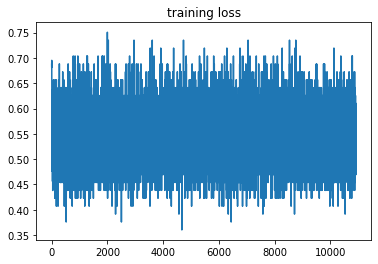

In [233]:
plt.plot(train_losses)
plt.title("training loss")

0.7480071997942916


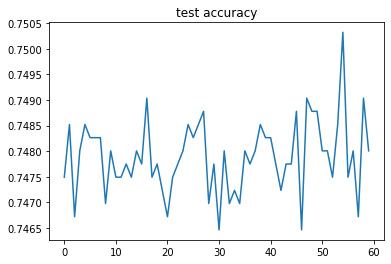

In [234]:
plt.plot(test_accuracy)
plt.title("test accuracy")
print(test_accuracy[-1])

In [235]:
model_path = f'saved_models/fold_{fold}/physionet_60epochs.pt'
print(model_path)

saved_models/fold_2/physionet_60epochs.pt


In [236]:
torch.save(model.state_dict(), model_path)
torch.save({
        'model_state_dict': model.state_dict(),
        'loss': train_losses[-1],
    }, model_path)

In [237]:
from torchmetrics import ConfusionMatrix
metric_cm = ConfusionMatrix(task='binary', num_classes=2).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    if data.shape != torch.Size([64,1,20000]):
            continue
    data = transforms(data)
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    metric_cm(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
    

In [239]:
cm = metric_cm.compute()
print(cm)

tensor([[   0,  931],
        [   0, 2909]], device='cuda:0')


In [240]:
2909/(2909+931)

0.7575520833333333

(128, 1, 2)
(128, 128, 3)


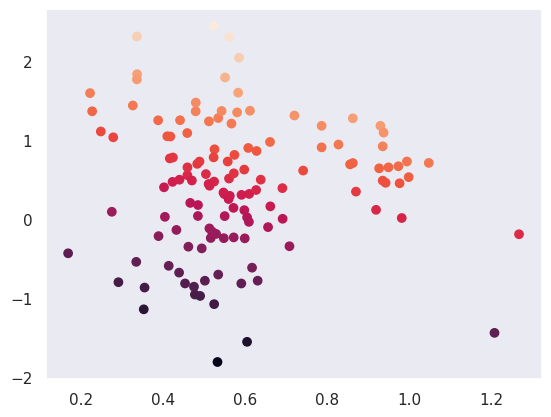

In [85]:
win_params1_list = model.conv1.window_params.detach().cpu().numpy()
win_params2_list = model.conv3.window_params.detach().cpu().numpy()
print(win_params1_list.shape)
print(win_params2_list.shape)
w1x = win_params1_list[..., 0].flatten()
w1y = win_params1_list[..., 1].flatten()
w1c = w1x + w1y
plt.scatter(w1x, w1y, c=w1c)

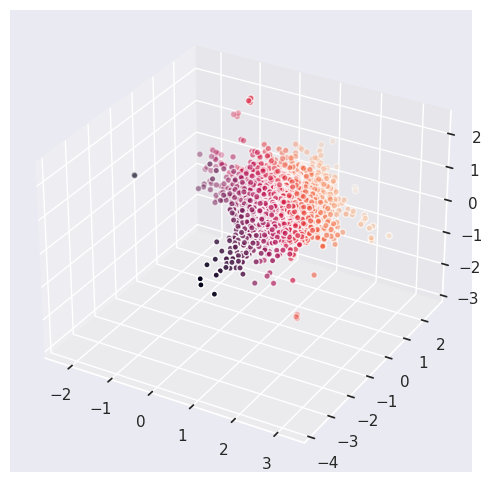

In [86]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection ='3d')

w2x = win_params2_list[...,0].flatten()
w2y = win_params2_list[...,1].flatten()
w2z = win_params2_list[...,2].flatten()
w2c = w2x + w2y
ax.set_xlim([w2x.min() - 0.1, w2x.max() + 0.1])
ax.set_ylim([w2y.min() - 0.1, w2y.max() + 0.1])
ax.set_zlim([w2z.min() - 0.1, w2z.max() + 0.1])
ax.scatter(w2x, w2y, w2z, c=w2c, edgecolor='white')

(array([2048., 3456., 3328., 2432., 2176., 1280.,  640.,  512.,  256.,
         256.]),
 array([0.0035846 , 0.0073439 , 0.01110321, 0.01486251, 0.01862181,
        0.02238112, 0.02614042, 0.02989972, 0.03365903, 0.03741833,
        0.04117763]),
 <BarContainer object of 10 artists>)

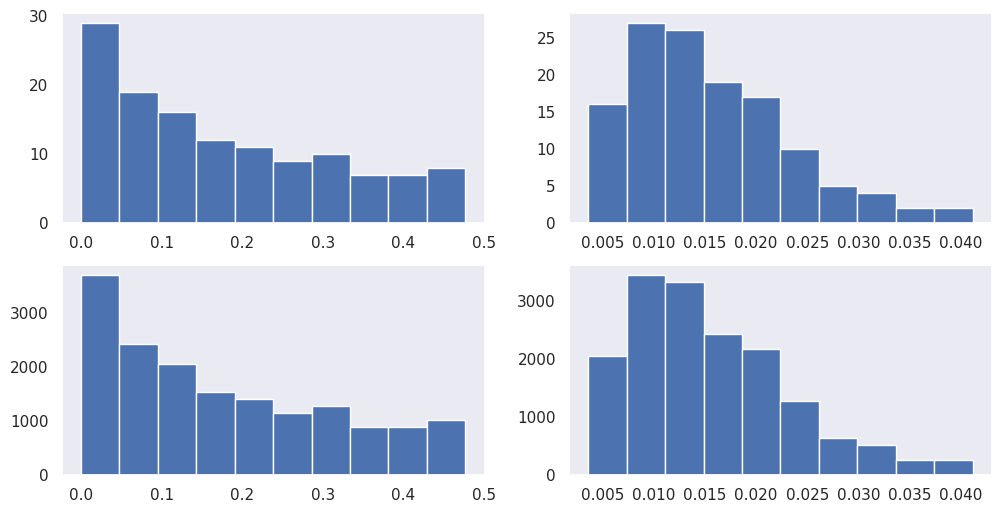

In [87]:
lowcut_bands1_m2 = model.conv1.lowcut_bands.detach().cpu().numpy()
bandwidths1_m2 = model.conv1.bandwidths.detach().cpu().numpy()
lowcut_bands2_m2 = model.conv3.lowcut_bands.detach().cpu().numpy()
bandwidths2_m2 = model.conv3.bandwidths.detach().cpu().numpy()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
axes[0,0].hist(lowcut_bands1_m2.flatten())
axes[0,1].hist(bandwidths1_m2.flatten())
axes[1,0].hist(lowcut_bands2_m2.flatten())
axes[1,1].hist(bandwidths2_m2.flatten())

In [88]:
y_n_bin = 5
y_bins = np.linspace(0.,lowcut_bands1_m2.max(), y_n_bin+1)
x_n_bin = 3
x_bins = np.linspace(0.,bandwidths1_m2.max(), x_n_bin+1)

df = pd.DataFrame(data={
    'lowcut': lowcut_bands1_m2.flatten(), 
    'bandwidth': bandwidths1_m2.flatten(), 
    'window_params': list(rearrange(win_params1_list, 'h c p -> (h c) p')) 
})
df

,lowcut,bandwidth,window_params
0,0.000000,0.003585,"[1.2665192, -0.18984407]"
1,0.003585,0.003878,"[0.7405523, 0.6172466]"
2,0.007463,0.004196,"[0.97263503, 0.67177904]"
3,0.011659,0.004540,"[0.92574286, 0.64570165]"
4,0.016199,0.004912,"[0.8266581, 0.9472456]"
...,...,...,...
123,0.389959,0.020805,"[0.5227404, 2.4496586]"
124,0.410764,0.021390,"[0.46951935, 0.4912453]"
125,0.432154,0.021991,"[0.60393727, -1.55355]"
126,0.454145,0.022610,"[0.55026144, 1.7974033]"


In [89]:
win_length = 17
df['lowcut_bin'] = df['lowcut'].apply(lambda x: 
                   max(math.ceil(x/lowcut_bands1_m2.max()*y_n_bin)-1, 0))
df['bandwidth_bin'] = df['bandwidth'].apply(lambda x: 
                   max(math.ceil(x/bandwidths1_m2.max()*x_n_bin)-1, 0))
df['window'] = df['window_params'].apply(lambda x:
                   general_cosine_window(win_length, x).numpy().flatten())
df['order'] = df.apply(
    lambda x: (y_n_bin -1 - x['lowcut_bin'])*x_n_bin + x['bandwidth_bin'], 
    axis=1)
df['order'].value_counts()

order
12    48
7     20
9     14
10    14
4     13
1      8
2      7
5      4
Name: count, dtype: int64

In [90]:
h, c = lowcut_bands1_m2.shape
df_expanded = pd.DataFrame(data={
    'lowcut': repeat(lowcut_bands1_m2, 'h c -> (h c k)', k=win_length), 
    'bandwidth': repeat(bandwidths1_m2, 'h c -> (h c k)', k=win_length),  
    'window': np.hstack(df['window'].values),
    'window_t': repeat(np.arange(win_length), 'k -> (h c k)', h=h, c=c, k=win_length),
    'lowcut_bin': repeat(df['lowcut_bin'].values, '(h c) -> (h c k)', h=h, c=c, k=win_length),
    'bandwidth_bin': repeat(df['bandwidth_bin'].values, '(h c) -> (h c k)', h=h, c=c, k=win_length),
    'order': repeat(df['order'].values, '(h c) -> (h c k)', h=h, c=c, k=win_length), 
    'win_id': repeat(np.arange(h*c), '(h c)-> (h c k)', h=h, c=c, k=win_length)
})
df_expanded

,lowcut,bandwidth,window,window_t,lowcut_bin,bandwidth_bin,order,win_id
0,0.000000,0.003585,1.456363,0,0,0,12,0
1,0.000000,0.003585,1.441912,1,0,0,12,0
2,0.000000,0.003585,1.400759,2,0,0,12,0
3,0.000000,0.003585,1.339169,3,0,0,12,0
4,0.000000,0.003585,1.266519,4,0,0,12,0
...,...,...,...,...,...,...,...,...
2171,0.476755,0.023245,0.597033,12,4,1,1,127
2172,0.476755,0.023245,0.356045,13,4,1,1,127
2173,0.476755,0.023245,0.151745,14,4,1,1,127
2174,0.476755,0.023245,0.015236,15,4,1,1,127


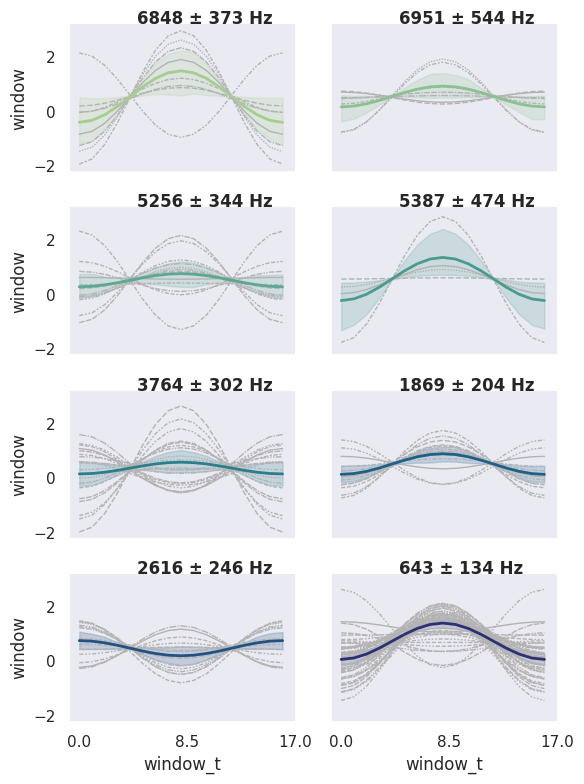

In [91]:
g = sns.relplot(
    data=df_expanded,
    x="window_t", 
    y='window', 
    col="order", hue="order",
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=2, 
    height=2, aspect=1.5, legend=False,
)

for order, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    sub_df = df_expanded[df_expanded['order']==order]
    subtitle = f"{int(sub_df['lowcut'].mean()*16000)} ± {int(sub_df['bandwidth'].mean()*16000)} Hz"
    ax.text(.3, 1, subtitle, transform=ax.transAxes, fontweight="bold")

    # Plot every window in the background
    sns.lineplot(
        data=sub_df, 
        x="window_t", 
        y="window", 
        units="order",
        estimator=None, color=".7", linewidth=1, ax=ax, 
        style="win_id", legend=False
    )
    
ax.set_xticks(np.linspace(0, win_length,3))
g.set_titles("")
g.tight_layout()

In [92]:
full_window_response_length = win_length*10
window_response_length = full_window_response_length
df['window_response'] = df['window'].apply(lambda x:
                   get_window_freq_response(x)[:window_response_length])
freq = np.fft.fftfreq(full_window_response_length,d=1/2)[:window_response_length]
h, c = lowcut_bands1_m2.shape
dff_expanded = pd.DataFrame(data={
    'lowcut': repeat(lowcut_bands1_m2, 'h c -> (h c k)', k=window_response_length), 
    'bandwidth': repeat(bandwidths1_m2, 'h c -> (h c k)', k=window_response_length),  
    'window_response': np.hstack(df['window_response'].values),
    'window_t': repeat(freq, 
                       'k -> (h c k)', h=h, c=c, k=window_response_length),
    'lowcut_bin': repeat(df['lowcut_bin'].values, 
                         '(h c) -> (h c k)', h=h, c=c, k=window_response_length),
    'bandwidth_bin': repeat(df['bandwidth_bin'].values, 
                            '(h c) -> (h c k)', h=h, c=c, k=window_response_length),
    'order': repeat(df['order'].values, 
                    '(h c) -> (h c k)', h=h, c=c, k=window_response_length), 
    'win_id': repeat(np.arange(h*c), '(h c)-> (h c k)', h=h, c=c, k=window_response_length)
})
dff_expanded

,lowcut,bandwidth,window_response,window_t,lowcut_bin,bandwidth_bin,order,win_id
0,0.000000,0.003585,0.000000,0.000000,0,0,12,0
1,0.000000,0.003585,-0.155971,0.011765,0,0,12,0
2,0.000000,0.003585,-0.631493,0.023529,0,0,12,0
3,0.000000,0.003585,-1.451207,0.035294,0,0,12,0
4,0.000000,0.003585,-2.663288,0.047059,0,0,12,0
...,...,...,...,...,...,...,...,...
21755,0.476755,0.023245,-1.126078,-0.058824,4,1,1,127
21756,0.476755,0.023245,-0.715730,-0.047059,4,1,1,127
21757,0.476755,0.023245,-0.400466,-0.035294,4,1,1,127
21758,0.476755,0.023245,-0.177317,-0.023529,4,1,1,127


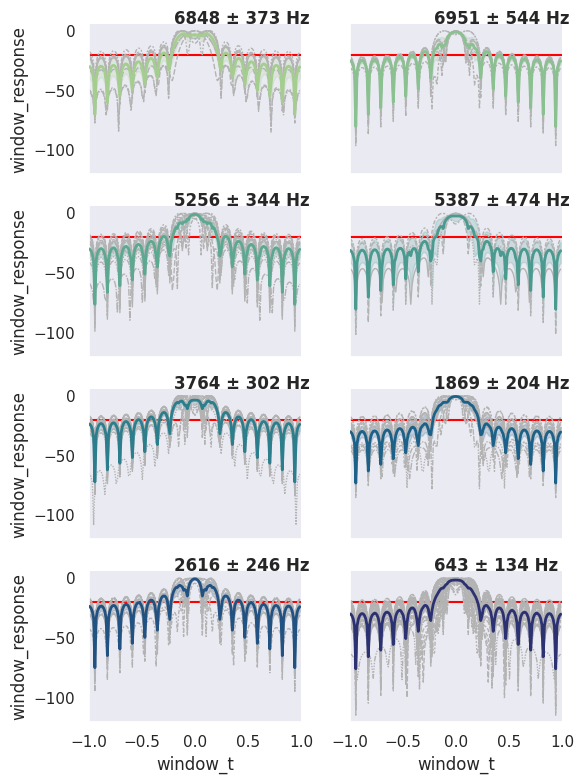

In [93]:
# sns.set(rc={'figure.figsize':(20,16)})
g = sns.relplot(
    data=dff_expanded,
    x="window_t", 
    y='window_response', 
    col="order", hue="order",
    # row='lowcut_bin', col='bandwidth_bin',
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=2, 
    height=2, aspect=1.5, legend=False,
)

for order, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    sub_df = dff_expanded[dff_expanded['order']==order]
    subtitle = f"{int(sub_df['lowcut'].mean()*16000)} ± {int(sub_df['bandwidth'].mean()*16000)} Hz"
    ax.text(.4, 1, subtitle, transform=ax.transAxes, fontweight="bold")
    ax.axhline(-20, color='red', zorder=1)
    
    # Plot every window in the background
    sns.lineplot(
        data=sub_df, 
        x="window_t", 
        y="window_response", 
        units="order",
        estimator=None, color=".7", linewidth=1, ax=ax, 
        style="win_id", legend=False
    )

    
    
# ax.set_xticks(np.linspace(0, win_length,3))
g.set_titles("")
g.set(xlim=[-1,1])
g.tight_layout()